In [1]:
###TODO: Check CE calculation
###TODO: Stack more layers

In [2]:
import time
import gc
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [3]:
pd.set_option('mode.chained_assignment', None)

In [4]:
run_params = {"Task": "train"
            , "Model": "generative task2seq"}

### Defining Methods

In [5]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [6]:
def preprocess_task(task_vector):
    # either convert to float32 or encode to categoricals
    for i, el in enumerate(task_vector):
        try:
            task_vector[i] = float(task_vector[i])
        except:
            task_vector[i] = get_key(cat_encodings[i], task_vector[i])
    return task_vector.astype('float32')

In [7]:
def group_by_notebooks(data:pd.DataFrame, vertex_col:str='vertex_l1') -> pd.DataFrame:
    notebook_cols = [[notebook_id_col, vertex_col, competition_id_col] + TASK_FEATURES]
    df = pd.DataFrame(columns=notebook_cols)
    for i, notebook_id in enumerate(data[notebook_id_col].unique()):
        notebook = data[data[notebook_id_col] == notebook_id].reset_index(drop=True)
        vertices_seq = " ".join(notebook[vertex_col])
        task_features = notebook[TASK_FEATURES].loc[0]
        competition_id = notebook[competition_id_col].unique()[0]
        row = [notebook_id, vertices_seq, competition_id] + task_features.tolist()
        df.loc[i] = row
        print('notebook #{} done'.format(notebook_id))
    return df 

In [8]:
def encode_vertices(vertices_seq): #, lang
    # print(vertices_seq[0], type(vertices_seq[0]), vertices_seq[0].split(' '))
    try:
        encoded = np.append(np.flip(np.array([lang[vertex] for vertex in vertices_seq[0].split(' ')] + [lang['<end>']])), lang['<start>'])
        # encoded = np.append(lang['<start>'], np.array([lang[vertex] for vertex in vertices_seq[0].split(' ')] + [lang['<end>']]))
    except:
        print(vertices_seq[0].split(' '))
        raise Exception("Can't encode vertices")
    return encoded

In [9]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru_1 = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.fc = tf.keras.layers.Dense(vocab_size, activation='sigmoid')
    self.fc_vec = tf.keras.layers.Dense(dec_units, activation='sigmoid')

  def call(self, x, hidden, vec_input):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    output, state = self.gru_1(x, initial_state=state)
    output = tf.reshape(output, (-1, output.shape[2]))
    output = self.dropout(output)
    vec = self.fc_vec(vec_input)
    concatenated = tf.keras.layers.concatenate([vec, output], axis=1)
    x = self.fc(concatenated)
    return x, state

In [10]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [11]:
@tf.function
def train_step(inp, targ): #decoder, optimizer, loss_function, 
  loss = 0
  with tf.GradientTape() as tape:
    dec_hidden = tf.zeros((BATCH_SIZE, gru_units))
    dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)
    for t in range(1, targ.shape[1]): # for each vertex (token) from solution (sequence)
      predictions, dec_hidden = decoder(dec_input, dec_hidden, inp) #decoder
      # print('target token: {}, \n predictions distribution: {}, \n old sum loss: {}'.format(targ[:, t], predictions, loss))
      loss += loss_function(targ[:, t], predictions)
      # print('new sum loss: {}, calculated loss: {}'.format(loss, loss_function(targ[:, t], predictions)))
      dec_input = tf.expand_dims(targ[:, t], 1)
  batch_loss = (loss / int(targ.shape[1]))
  variables = decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  del inp, targ, gradients, variables
  gc.collect()
  return batch_loss

In [12]:
# @tf.function
# def train_generator(STEPS_PER_EPOCH, EPOCHS, ):
#     @tf.function
#     def train_step(inp, targ): #decoder, optimizer, loss_function, 
#         loss = 0
#         with tf.GradientTape() as tape:
#             dec_hidden = tf.zeros((BATCH_SIZE, gru_units))
#             dec_input = tf.expand_dims([1] * BATCH_SIZE, 1)
#             for t in range(1, targ.shape[1]): # for each vertex (token) from solution (sequence)
#             predictions, dec_hidden = decoder(dec_input, dec_hidden, inp) #decoder
#             loss += loss_function(targ[:, t], predictions)
#             dec_input = tf.expand_dims(targ[:, t], 1)

#         batch_loss = (loss / int(targ.shape[1]))
#         variables = decoder.trainable_variables
#         gradients = tape.gradient(loss, variables)
#         optimizer.apply_gradients(zip(gradients, variables))
#         del inp, targ, gradients, variables
#         gc.collect()
#         return batch_loss
#     for epoch in range(EPOCHS):
#         gc.collect()
#         start = time.time()
#         total_loss = 0
#         for (batch, (feat, targ)) in enumerate(train_dataset.take(STEPS_PER_EPOCH)):
#             batch_loss = train_step(feat, targ)#, enc_hidden)
#             batch_perplexity = tf.exp(batch_loss)
#             total_loss += batch_loss
#             if batch % 100 == 0:
#                 print('Epoch {} Batch {} Loss {:.4f} Perplexity {:.4f}'.format(epoch + 1,
#                                                                 batch,
#                                                                 batch_loss.numpy(),
#                                                                 batch_perplexity))
#         train_losses.append(batch_loss)

#         print('Validating')
#         _, losses_ce, rouge_recalls, rouge_precisions = predict_on_test(X_test[TASK_FEATURES], Y_test)
#         val_ce.append(losses_ce)
#         val_rr.append(rouge_recalls)
#         val_rp.append(rouge_precisions)
#         if (epoch + 1) % 5 == 0:
#             print('Saving..', end='')
#             checkpoint.step.assign_add(5)
#             manager.save()
#             print('saved')
#         print('Time taken for the epoch {} sec\n'.format(time.time() - start))
#     best_epoch = np.argmin(val_ce, axis=1)
#     print('The best epoch is {} with CE = {}, RR = {}, RP = {}'.format(best_epoch, val_ce[best_epoch], val_rr[best_epoch], val_rp[best_epoch]))
#     plt.plot(train_losses)
#     plt.plot(np.mean(val_ce, axis=1)/10000)
#     plt.plot(np.mean(val_rr, axis=1))
#     plt.plot(np.mean(val_rp, axis=1))

In [13]:
def generate_solution(task_vector, save_outputs:bool=False):
  attention_plot = np.zeros((max_length_targ, max_length_feat))
  task_vector = preprocess_task(task_vector)
  inputs = tf.expand_dims(tf.convert_to_tensor(task_vector), axis=0)
  result = ''

  dec_hidden = tf.zeros((BATCH_SIZE, gru_units))
  dec_input = tf.expand_dims([1], 0)
  loss = 0
  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input
                                      , dec_hidden
                                      , inputs)
    # storing the attention weights to plot later on
    # attention_weights = tf.reshape(attention_weights, (-1, ))
    # attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    predicted_vertice = get_key(lang, predicted_id)
    if (predicted_vertice != ' ')&(predicted_vertice != ''):
      # loss += loss_function(true_vector, predictions)
      # print(loss)
      result = predicted_vertice + ' ' + result #targ_lang.index_word[predicted_id] + ' '
    elif (predicted_vertice == '<start>')&(predicted_vertice == '<end>'):
      print('Evaluation: found start/end, ending')
      return result, task_vector#, attention_plot
    
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)
  if save_outputs:
    OUTPUT_FILE = './task2seq/outputs/output.py'
    with open(OUTPUT_FILE, 'w') as f:
        last_vertice = ''
        for vertice in result.split(' '):
            if vertice:
                if (vertice!='<start>')&(vertice!='<end>')&(vertice!=last_vertice):
                    line = '#@ {} \n\n'.format(vertice)
                    f.write(line)
                    last_vertice = vertice
  return result, task_vector#, attention_plot

In [14]:
def generate_solution_with_evaluation(task_vector, true_sequence:np.array, save_outputs:bool=False):
    task_vector = preprocess_task(task_vector)
    inputs = tf.expand_dims(tf.convert_to_tensor(task_vector), axis=0)
    generated_sequence_string = ''
    generated_sequence_array = []
    metrics = {}

    dec_hidden = tf.zeros((BATCH_SIZE, gru_units))
    dec_input = tf.expand_dims([1], 0)
    loss = 0
    for t in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input
                                          , dec_hidden
                                          , inputs)
        predicted_id = tf.argmax(predictions[0]).numpy()
        generated_sequence_array.append(predicted_id)

        predicted_vertice = get_key(lang, predicted_id)
        if (predicted_vertice != ' ')&(predicted_vertice != ''):
            # print('true sequence: {}, type[t]: {}, type: {}'.format(true_sequence[t], type(true_sequence[t]), type(true_sequence)))
            # print('predictions: {}, type: {}'.format(predictions, type(predictions)))
            loss += loss_function(true_sequence[t], predictions)
            generated_sequence_string = predicted_vertice + ' ' + generated_sequence_string
        elif (predicted_vertice == '<start>')&(predicted_vertice == '<end>'):
            print('Evaluation: found start/end, ending')
            return generated_sequence_string, metrics

        dec_input = tf.expand_dims([predicted_id], 0)
    # print('loss: {}, type: {}. len(true_sequence) == {}, shape == {}'.format(loss, type(loss), len(true_sequence), true_sequence.shape))
    ce = loss.numpy()/len(true_sequence)
    metrics.update({"Cross-Entropy":ce,
                  "Perplexity":tf.exp(ce),
                  "ROUGE-Recall":rouge_recall(true_sequence, generated_sequence_array),
                  "ROUGE-Precision": rouge_precision(true_sequence, generated_sequence_array)
                #   , "Nunique_Tokens": np.unique(generated_sequence_string)
                  })
    if save_outputs:
        TODAY_NOW = datetime.now().strftime("%d-%m-%y_%H-%M-%S")
        save_generated_sequence(generated_sequence_string, output_path='./outputs/output_{}.py'.format(TODAY_NOW))
    return generated_sequence_string, metrics

In [15]:
def predict_on_test(X_test, Y_test):
    y_pred = []
    losses_ce = []
    rouge_recalls = []
    rouge_precisions = []
    # nunique_tokens = []
    print('predicting..', end=' ')
    for i, task_vector in X_test.reset_index(drop=True).iterrows():
        if i % 10 == 0:
            print('{:.1%}'.format(i/X_test.shape[0]), end=' ')
        true_vector = Y_test[i]
        result, metrics = generate_solution_with_evaluation(task_vector, true_vector)
        # print(loss.numpy())
        y_pred.append(result[:-1])
        losses_ce.append(metrics['Cross-Entropy'])
        rouge_recalls.append(metrics['ROUGE-Recall'])
        rouge_precisions.append(metrics['ROUGE-Precision'])
        # nunique_tokens.append(metrics['Nunique_Tokens'])
    print()
    y_pred = pd.DataFrame(y_pred, columns=[TARGET_COLUMN])
    print('Cross-Entropy: {:.4f}'.format(np.mean(losses_ce)))
    print('Perplexity: {:.4f}'.format(np.exp(float(np.mean(losses_ce)))))
    print('ROUGE-Recall: {:.4f}'.format(np.mean(rouge_recalls)))
    print('ROUGE-Precision: {:.4f}'.format(np.mean(rouge_precisions)))
    # print('Avg nunique tokens: {}'.format(np.mean(nunique_tokens)))
    print('Unique answers: {}'.format(y_pred[TARGET_COLUMN].nunique()))
    
    return y_pred, losses_ce, rouge_recalls, rouge_precisions

In [16]:
def rouge_recall(true_string_vector:list, predicted_string_vector:list) -> float:
    true_string_vector = [el for el in true_string_vector if el != 0]
    # predicted_string_vector = [el for el in predicted_string_vector if el != 0]
    n_overlapping_words = len(set(true_string_vector).intersection(set(predicted_string_vector)))
    total_words_in_output = len(predicted_string_vector)
    return n_overlapping_words / total_words_in_output

In [17]:
def rouge_precision(true_string_vector:list, predicted_string_vector:list) -> float:
    true_string_vector = [el for el in true_string_vector if el != 0]
    n_overlapping_words = len(set(true_string_vector).intersection(set(predicted_string_vector)))
    total_words_in_reference = len(true_string_vector)
    return n_overlapping_words / total_words_in_reference

In [18]:
def save_generated_sequence(generated_sequence_string:str, output_path:str):
    # OUTPUT_FILE = './task2seq/outputs/output.py'
    with open(output_path, 'w') as f:
        last_vertice = ''
        for vertice in generated_sequence_string.split(' '):
            if vertice:
                if (vertice!='<start>')&(vertice!='<end>')&(vertice!=last_vertice):
                    line = '#@ {} \n\n'.format(vertice)
                    f.write(line)
                    last_vertice = vertice

---

### Data Preprocessing Parameters

In [19]:
EXPORT_DATE = '2021-05-26'
REMOVE_RECURRINGS = True
TEST_SIZE = test_size = 0.2

### Reading Data

In [20]:
graph_path = '../../data/actual_graph_{}.csv'.format(EXPORT_DATE)
graph = pd.read_csv(graph_path)
graph.rename({'id':'graph_vertex_id'}, axis=1, inplace=True)
graph.columns

Index(['graph_vertex_id', 'graph_vertex', 'graph_vertex_subclass'], dtype='object')

In [21]:
COMPETITIONS_PATH = "../../data/competitions_info_cleaned_filled.csv" #./data/competitions_info_cleaned.csv
competitions_filled = pd.read_csv(COMPETITIONS_PATH)
competitions_filled.drop_duplicates(inplace=True)
competitions_filled.rename({'Description': 'description', 'Metric':'metric', 'DataType':'datatype', 'Subject':'subject', 'ProblemType':'problemtype'}
                        , axis=1, inplace=True)
competitions_filled.shape

(266, 8)

In [22]:
competitions_filled.isna().sum()

ref             0
comp_name       0
comp_type       0
description    21
metric         19
datatype       19
subject        19
problemtype    19
dtype: int64

In [23]:
competitions_filled['ref'] = competitions_filled['ref'].str.replace("'", "")

In [24]:
COMPETITIONS_PATH = "../../data/competitions_{}.csv".format(EXPORT_DATE) #./data/competitions_info_cleaned.csv
competitions = pd.read_csv(COMPETITIONS_PATH)
competitions.drop_duplicates(inplace=True)
competitions.shape

(5060, 10)

In [25]:
# competitions['ref'] = competitions['ref'].apply(lambda x: x.split(',')[0])
# competitions['ref'] = competitions['ref'].str.replace("'", "")

In [26]:
# competitions['exists_in_comp_filled'] = competitions.apply(lambda x: x['ref'] in competitions_filled['ref'].unique(), axis=1)
# competitions['exists_in_comp_filled'].value_counts()

In [27]:
# competitions_filled.merge(competitions[['id', 'ref']], on=['ref']).shape

In [28]:
competitions = competitions_filled.merge(competitions[['id', 'ref_link']], how='inner', left_on=['ref'], right_on=['ref_link'])
competitions.shape

(312, 10)

In [29]:
competitions.isna().sum()

ref             0
comp_name       0
comp_type       0
description    26
metric         23
datatype       23
subject        23
problemtype    23
id              0
ref_link        0
dtype: int64

In [30]:
# NOTEBOOKS_PATH = "../../data/codeblocks_2021-04-01_concatenated_cleaned_linkedwithcompetitions_pred.csv"
NOTEBOOKS_PATH = '../../data/markup_data_{}.csv'.format(EXPORT_DATE)
notebooks = pd.read_csv(NOTEBOOKS_PATH)
notebooks.head(5)

,code_block_id,code_block,data_format,graph_vertex_id,errors,marks,kaggle_id,competition_id
0,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,3868
1,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,3868
2,570368,`# load training and testing data \nsubm = pd....,Table,45,No,5,8591010,3868
3,570369,`subm`,Table,41,No,5,8591010,3868
4,570367,`# My forecasting COVID-19 confirmed cases and...,Table,45,No,2,8591010,3868


In [31]:
notebooks = notebooks.merge(graph, on='graph_vertex_id', how='left')
notebooks.shape

(5933, 10)

In [32]:
# nl2ml = notebooks.merge(competitions[['ref', 'id']], left_on=['ref'], right_on=['ref'], how='inner').rename({'id':'competition_id'}, axis=1)
nl2ml = notebooks.merge(competitions, left_on=['competition_id'], right_on=['id'], how='inner')
print(nl2ml.shape[0])
nl2ml.drop_duplicates(inplace=True, subset=['code_block_id', 'kaggle_id'])
print(nl2ml.shape[0])

3208
3111


In [33]:
print(nl2ml['kaggle_id'].nunique(), nl2ml['ref'].nunique())

113 7


### Vertices Preprocessing

In [34]:
nl2ml['graph_vertex'].apply(lambda x: x.split(';')[0].split('.')[0]).value_counts()

Data_Transform          936
EDA                     747
Model_Train             287
Visualization           281
Environment             202
Data_Extraction         168
Other                   147
Hyperparam_Tuning       120
Data_Export             104
Model_Evaluation         95
Model_Interpretation     21
Hypothesis                3
Name: graph_vertex, dtype: int64

In [35]:
nl2ml['vertex_l1'], nl2ml['vertex_l2'] = nl2ml['graph_vertex'].apply(lambda x: x.split(';')[0].split('.')[0]), nl2ml['graph_vertex_subclass']#.apply(lambda x: x.split(';')[0].split('.')[1])

### Missing Values

In [36]:
nl2ml.replace('-', -1, inplace=True)
print(nl2ml.isna().sum())
nl2ml.fillna(-1, inplace=True)
print(nl2ml.isna().sum())

code_block_id            0
code_block               0
data_format              0
graph_vertex_id          0
errors                   0
marks                    0
kaggle_id                0
competition_id           0
graph_vertex             0
graph_vertex_subclass    0
ref                      0
comp_name                0
comp_type                0
description              0
metric                   0
datatype                 0
subject                  0
problemtype              0
id                       0
ref_link                 0
vertex_l1                0
vertex_l2                0
dtype: int64
code_block_id            0
code_block               0
data_format              0
graph_vertex_id          0
errors                   0
marks                    0
kaggle_id                0
competition_id           0
graph_vertex             0
graph_vertex_subclass    0
ref                      0
comp_name                0
comp_type                0
description              0
metric         

In [37]:
# TASK_FEATURES = ['comp_name', 'comp_type', 'Description', 'Metric', 'DataType', 'Subject', 'ProblemType']
TASK_FEATURES = ['comp_name', 'comp_type', 'description', 'metric', 'datatype', 'subject', 'problemtype']

In [38]:
TARGET_COLUMN = 'vertex_l2'

### Grouping chunks by notebooks

In [39]:
notebook_id_col = 'kaggle_id'
competition_id_col = 'competition_id'

### Taking Train Features

In [40]:
# nl2ml = group_by_notebooks(nl2ml, TARGET_COLUMN)
# X, y = train[TASK_FEATURES], train[TARGET_COLUMN]
prepared_data = group_by_notebooks(nl2ml, TARGET_COLUMN)
prepared_data.shape

notebook #8591010 done
notebook #8592598 done
notebook #8596735 done
notebook #8606894 done
notebook #8609050 done
notebook #8611767 done
notebook #8630977 done
notebook #8634286 done
notebook #8640194 done
notebook #8660923 done
notebook #8667455 done
notebook #8668446 done
notebook #8678201 done
notebook #8687334 done
notebook #8689318 done
notebook #8699382 done
notebook #8705213 done
notebook #8706858 done
notebook #8708118 done
notebook #8710137 done
notebook #8710362 done
notebook #8604602 done
notebook #8617043 done
notebook #8620454 done
notebook #8625834 done
notebook #8628909 done
notebook #8658083 done
notebook #8663175 done
notebook #8671133 done
notebook #8679319 done
notebook #8682800 done
notebook #8687249 done
notebook #8693806 done
notebook #8701862 done
notebook #8702904 done
notebook #8706295 done
notebook #8711165 done
notebook #9326374 done
notebook #9349764 done
notebook #9463384 done
notebook #138832 done
notebook #2637869 done
notebook #5466844 done
notebook #57

(113, 10)

### Converting Dtypes

In [41]:
def strip_recurrent_vertices(row):
    # sequence = row['vertex_l2'].split(' ')
    # result = []
    # if len(sequence) > 1:
    #     last_index = len(sequence) - 1
    #     i = 0
    #     while i < last_index:
    #         # print(sequence[i], sequence[i+1])
    #         if sequence[i].strip(' ') != sequence[i+1].strip(' '):
    #             # print('not equal')
    #             result.append(sequence[i])
    #         else:
    #             print('equal', sequence[i], sequence[i+1])
    #         i =+ 1
    # return " ".join(result)
    result = row['vertex_l2'].split(' ')[0] + " " + " ".join([row['vertex_l2'].split(' ')[i] for i in range(1, len(row['vertex_l2'].split(' '))) if (row['vertex_l2'].split(' ')[i-1] != row['vertex_l2'].split(' ')[i])&(row['vertex_l2'].split(' ')[i] != ' ')&(row['vertex_l2'].split(' ')[i] != '')])
    if result.split(' ')[1] == ' ':
        result.pop(1)
        return result
    else:
        return " ".join(row['vertex_l2'].split(' '))

In [42]:
if REMOVE_RECURRINGS:
    print('removing')
    prepared_data[TARGET_COLUMN] = prepared_data[TARGET_COLUMN].apply(strip_recurrent_vertices, axis=1)
# prepared_data[TARGET_COLUMN] = prepared_data[TARGET_COLUMN].apply(lambda x: x.replace(' ', ''))

removing


In [43]:
cat_encodings = {}
print('Encoding columns: ')
for i, col in enumerate(prepared_data):
    if col[0] != TARGET_COLUMN:
        print(col[0])
        try:
            prepared_data[col] =  prepared_data[col].astype('float32')
        except:
            prepared_data[col] = pd.Categorical(prepared_data[col])
            cat_encodings.update({i:dict(enumerate(prepared_data[col].cat.categories))})
            prepared_data[col] = prepared_data[col].cat.codes

Encoding columns: 
kaggle_id
competition_id
comp_name
comp_type
description
metric
datatype
subject
problemtype


In [44]:
competitions = prepared_data[competition_id_col].iloc[:, 0].unique()
n_test_competitions = round(test_size * len(competitions))
# n_val_competitions = test_size // 2
test_competitions, train_competitions = competitions[:n_test_competitions], competitions[n_test_competitions:]
# test_competitions, val_competitions = test_competitions[:n_val_competitions], test_competitions[n_val_competitions:]
train = prepared_data[prepared_data['competition_id'].iloc[:, 0].isin(train_competitions)]
test = prepared_data[prepared_data['competition_id'].iloc[:, 0].isin(test_competitions)]
# val = prepared_data[prepared_data['competition_id'].iloc[:, 0].isin(val_competitions)]
X_train, y_train = train[TASK_FEATURES], train[TARGET_COLUMN]
X_test, y_test = test[TASK_FEATURES], test[TARGET_COLUMN]
# X_val, y_val = val[TASK_FEATURES], val[TARGET_COLUMN]
X_train.shape, X_test.shape
# X_val.shape

((73, 7), (40, 7))

In [45]:
# X_train, X_test, y_train, y_test = train_test_split(prepared_data[TASK_FEATURES], prepared_data[TARGET_COLUMN]
#                                                     , test_size=0.25, shuffle=True, random_state=123)
# X_train.shape, X_test.shape

### Target Preprocessing: Encoding Vertices

In [46]:
lang = {vertice:i+2 for i, vertice in enumerate(nl2ml[TARGET_COLUMN].unique())} #TODO: save the dict as a local file
lang.update({'<start>':1, '<end>':max(lang.values())+1})

In [47]:
# y_train.apply(encode_vertices, axis=1)

In [48]:
# X[TARGET_COLUMN] = y.apply(encode_vertices, axis=1)
# X.to_csv('../data/nl2ml_train_example.csv', index=False)

### Target Preprocessing: Padding Sequences

In [49]:
max_length_targ, max_length_feat = prepared_data[TARGET_COLUMN].squeeze().str.split(' ').str.len().max() + 2, X_train.values.shape[1]
max_length_targ, max_length_feat

(116, 7)

In [50]:
Y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train.apply(encode_vertices, axis=1), maxlen=max_length_targ)
Y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test.apply(encode_vertices, axis=1), maxlen=max_length_targ)

### Model Parameters

In [51]:
n_features = len(TASK_FEATURES)

In [52]:
dataset_params = {"nrows": X_train.shape[0]
                , "nfeatures": n_features
                , "EXPORT_DATE": EXPORT_DATE
                , "REMOVE_RECURRINGS": REMOVE_RECURRINGS
                , "TEST_SIZE": TEST_SIZE}

In [53]:
# ## Configuration 1
# LR = 0.001  
# EPOCHS = 200
# gru_units = 512
# embedding_dim = 256
# dropout_rate = 0.2
# BATCH_SIZE = 1
# STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE

In [54]:
## Configuration 1.1
LR = 0.001
EPOCHS = 100
gru_units = 1024
embedding_dim = 512
dropout_rate = 0.2
BATCH_SIZE = 1
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE

In [55]:
# ## Configuration 2
# LR = 0.002
# EPOCHS = 100
# gru_units = 256
# embedding_dim = 128
# dropout_rate = 0.0
# BATCH_SIZE = 1
# STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE
# # BUFFER_SIZE = len(input_tensor_train)
# # vocab_inp_size = len(inp_lang.word_index) + 1
# # vocab_tar_size = len(targ_lang.word_index) + 1

In [56]:
# ## Configuration 3
# LR = 0.002
# EPOCHS = 100
# gru_units = 128
# embedding_dim = 64
# dropout_rate = 0.0
# BATCH_SIZE = 1
# STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE

In [57]:
model_params = {"BATCH_SIZE":BATCH_SIZE
                , "LR":LR
                , "STEPS_PER_EPOCH": STEPS_PER_EPOCH
                , "embedding_dim": embedding_dim
                , "gru_units": gru_units
                , "dropout_rate": dropout_rate}

### Creating tf.Dataset

In [58]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, Y_train))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True) 

### Building the Model

In [59]:
decoder = Decoder(len(lang)+2, embedding_dim, gru_units, BATCH_SIZE)
sample_hidden = tf.zeros((BATCH_SIZE, gru_units))
vec_input = np.ones((1, n_features))
sample_decoder_output, state = decoder(tf.random.uniform((BATCH_SIZE, 1))
                                          , sample_hidden
                                          , vec_input
                                          )
print ('Decoder output shape: (batch_size, vocab size`) {}'.format(sample_decoder_output.shape))
decoder.summary()

Decoder output shape: (batch_size, vocab size`) (1, 72)
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  36864     
_________________________________________________________________
gru (GRU)                    multiple                  4724736   
_________________________________________________________________
gru_1 (GRU)                  multiple                  4724736   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  147528    
_________________________________________________________________
dense_1 (Dense)              multiple                  8192      
Total params: 9,642,056
Trainable params: 9,642,056
Non-trainable par

In [60]:
optimizer = tf.keras.optimizers.Adam(LR)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none') ##True

### Model Training or Loading Pre-Trained

In [61]:
checkpoint_dir = './checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(step=tf.Variable(1)
                                , optimizer=optimizer
                                 , decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=200)

In [62]:
# if manager.latest_checkpoint:
#     print("Restored from {}".format(manager.latest_checkpoint))

In [63]:
# decoder.compile(
#     optimizer=optimizer,
#     loss=loss_object
# )
# tf.saved_model.save(decoder, './checkpoints/model1.h5')

In [64]:
train_losses = []
val_ce = []
val_rr = []
val_rp = []

Epoch 1 Batch 0 Loss 0.3857 Perplexity 1.4706
Validating
predicting.. 0.0% 
Cross-Entropy: 1.1113
Perplexity: 3.0385
ROUGE-Recall: 0.0017
ROUGE-Precision: 0.0065
Unique answers: 1
Time taken for the epoch 536.7178282737732 sec

Epoch 2 Batch 0 Loss 0.2624 Perplexity 1.3001
Validating
predicting.. 0.0% 
Cross-Entropy: 1.1735
Perplexity: 3.2332
ROUGE-Recall: 0.0050
ROUGE-Precision: 0.0216
Unique answers: 1
Time taken for the epoch 82.20626640319824 sec

Epoch 3 Batch 0 Loss 0.2686 Perplexity 1.3081
Validating
predicting.. 0.0% 
Cross-Entropy: 1.3425
Perplexity: 3.8288
ROUGE-Recall: 0.0050
ROUGE-Precision: 0.0216
Unique answers: 1
Time taken for the epoch 76.67726612091064 sec

Epoch 4 Batch 0 Loss 0.2370 Perplexity 1.2674
Validating
predicting.. 0.0% 
Cross-Entropy: 1.2522
Perplexity: 3.4981
ROUGE-Recall: 0.0050
ROUGE-Precision: 0.0216
Unique answers: 1
Time taken for the epoch 77.32824444770813 sec

Epoch 5 Batch 0 Loss 0.2155 Perplexity 1.2405
Validating
predicting.. 0.0% 
Cross-Entrop

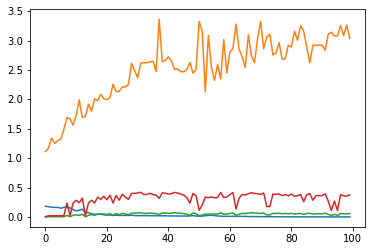

In [141]:
for epoch in range(EPOCHS):
    gc.collect()
    start = time.time()
    # enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_batch_perplexity = 0
    for (batch, (feat, targ)) in enumerate(train_dataset.take(STEPS_PER_EPOCH)):
        batch_loss = train_step(feat, targ)#, enc_hidden)
        batch_perplexity = tf.exp(batch_loss)

        total_loss += batch_loss
        total_batch_perplexity += batch_perplexity
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                            batch,
                                                            batch_loss.numpy()), end=' ')
            print('Perplexity {:.4f}'.format(batch_perplexity))
    train_losses.append(batch_loss)
    print('Validating')
    _, losses_ce, rouge_recalls, rouge_precisions = predict_on_test(X_test[TASK_FEATURES], Y_test)
    val_ce.append(losses_ce)
    val_rr.append(rouge_recalls)
    val_rp.append(rouge_precisions)
    if (epoch + 1) % 5 == 0:
        print('Saving..', end='')
        checkpoint.step.assign_add(5)
        manager.save()
        print('saved')
    print('Time taken for the epoch {} sec\n'.format(time.time() - start))
best_epoch = np.argmin(np.mean(val_ce, axis=1)) + 1
print('The best epoch is {} with CE = {:.4f}, RR = {:.4f}, RP = {:.4f}'.format(best_epoch, np.mean(val_ce[best_epoch]), np.mean(val_rr[best_epoch]), np.mean(val_rp[best_epoch])))
plt.plot(train_losses)
plt.plot(np.mean(val_ce, axis=1))
plt.plot(np.mean(val_rr, axis=1))
plt.plot(np.mean(val_rp, axis=1))

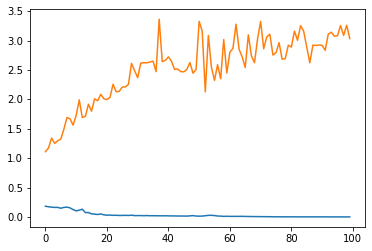

In [142]:
plt.plot(train_losses)
plt.plot(np.mean(val_ce, axis=1))

In [143]:
np.max(np.mean(val_rp, axis=1))

0.4199863995505681

42
31


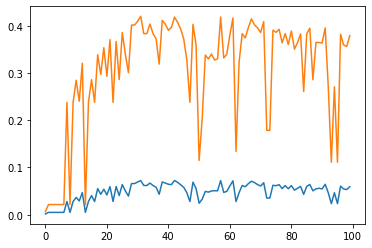

In [144]:
plt.plot(np.mean(val_rr, axis=1))
print(np.argmax(np.mean(val_rr, axis=1)))
plt.plot(np.mean(val_rp, axis=1))
print(np.argmax(np.mean(val_rp, axis=1)))

In [145]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Sequence Generation

In [146]:
# i = 0
# example_task_vector = X_test.reset_index(drop=True).loc[i]
# example_true_vector = Y_test[i]
# example_true_sequence = y_test.loc[i][0]
# print('task vector: {} \n'.format(example_task_vector.values))
# print('true sequence is: {}\n'.format(example_true_sequence))
# result, task_vector = generate_solution(example_task_vector)
# print(result, '\n')
# print('length of the result sequence is: {} \n'.format(len(result.split(' '))))

### Model Evaluation

In [147]:
# i = 0
# example_task_vector = X_test.reset_index(drop=True).loc[i]
# example_true_vector = Y_test[i]
# example_true_sequence = y_test.loc[i][0]
# print('task vector: {} \n'.format(example_task_vector.values))
# print('true sequence is: {}\n'.format(example_true_sequence))
# result, metrics = generate_solution_with_evaluation(example_task_vector, example_true_vector, save_outputs=True)
# print('predicted sequence is: {}\n'.format(result))
# print('predicted unique sequence is: {}\n'.format(" ".join(list(set(result.split(' ')))))) #[el for i, el in enumerate(result.split(' ')) if result.split(' ')[i-1] != el])
# print('length of the result sequence is: {} \n'.format(len(result.split(' '))))
# print('Metrics:', metrics)

In [148]:
## Predict on Train
_, _, _, _ = predict_on_test(X_train[TASK_FEATURES], Y_train)

predicting.. 0.0% 
Cross-Entropy: 2.6955
Perplexity: 14.8133
ROUGE-Recall: 0.0849
ROUGE-Precision: 0.4622
Unique answers: 6


In [149]:
## Predict on Test
_, _, _, _ = predict_on_test(X_test[TASK_FEATURES], Y_test)

predicting.. 0.0% 
Cross-Entropy: 3.0341
Perplexity: 20.7832
ROUGE-Recall: 0.0593
ROUGE-Precision: 0.3790
Unique answers: 1


In [150]:
# val_ce = []
# val_rr = []
# val_rp = []
# for i in range(1, EPOCHS//5 + 1):
#     checkpoint.restore('./checkpoints/ckpt-{}.index'.format(i))
#     _, losses_ce, rouge_recalls, rouge_precisions = predict_on_test(X_test[TASK_FEATURES], Y_test)
#     val_ce.append(losses_ce)
#     val_rr.append(rouge_recalls)
#     val_rp.append(rouge_precisions)

In [151]:
# y_pred[TARGET_COLUMN].unique()

---
## To Do

In [152]:
##TODO: To py and argparse

### To DAGsHub

In [153]:
# ##TODO: Export to DAGsHub
# experiment_params = run_params.update(model_params)
# experiment_params = experiment_params.update(data_params)
# print(experiment_params)
# # experiment_results = {}